### This is the notebook for the blog snowflake dask to show parallel processing of snowflake results in a dask cluster

Install the Snowflake Connect Python Module with Pandas

In [2]:
# !pip install snowflake-connector-python[pandas]

### Load snowflake configuration from config file. 
This is for demo purpose, in the real production code, you would need to put the snowflake connection info into secrets use the secrets in the running pod to connect to snowflake

In [35]:
import yaml
import os
# Load connection info
with open("/User/config.yaml") as f:
    connection_info = yaml.safe_load(f)

# verify the config
print(connection_info['user'])

xingsheng


### Load snowflake pem private key from a file. Note here you will need to replace the key file with your own file path and key file

In [37]:
import snowflake.connector
import os
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization    

pk_path = connection_info['pkPath']
pk_password = connection_info['pkPassword']
sf_password = connection_info['password']

if pk_path and pk_password:
    with open(pk_path, "rb") as key:
        p_key= serialization.load_pem_private_key(
            key.read(),
            password=str(pk_password).encode(),
            backend=default_backend()
        )
    pkb = p_key.private_bytes(
        encoding=serialization.Encoding.DER,
        format=serialization.PrivateFormat.PKCS8
        ,encryption_algorithm=serialization.NoEncryption()
    )
    connection_info.pop('password', 'No password found')
    connection_info['private_key'] = pkb
elif sf_password:
    connection_info['password'] = sf_password
else:
    raise Exception("\nPlease set up the secret for Snowflake in your project!\n")

### A simple example of using snowflake python connector
If you are using a distributed environment to parallelize workloads, you can use the Snowflake Connector for Python to distribute the work of fetching and processing results.<br>
In this example, we create a connection to snowflake, execute a query and fetch the query results to a panda dataframe (assuming the resultset can fit into the memory)

In [38]:
import pandas as pd
import snowflake.connector as snow

ctx = snow.connect(**connection_info)

query = "SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF1.CUSTOMER"

# old, slow way
# pd.read_sql(query, ctx)

# a faster way to load
cur = ctx.cursor()
cur.execute(query)
df = cur.fetch_pandas_all()
df.head()

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,30001,Customer#000030001,"Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst",4,14-526-204-4500,8848.47,MACHINERY,frays wake blithely enticingly ironic asymptote
1,30002,Customer#000030002,UVBoMtILkQu1J3v,11,21-340-653-9800,5221.81,MACHINERY,he slyly ironic pinto beans wake slyly above t...
2,30003,Customer#000030003,CuGi9fwKn8JdR,21,31-757-493-7525,3014.89,BUILDING,e furiously alongside of the requests. evenly ...
3,30004,Customer#000030004,tkR93ReOnf9zYeO,23,33-870-136-4375,3308.55,AUTOMOBILE,ssly bold deposits. final req
4,30005,Customer#000030005,pvq4uDoD8pEwpAE01aesCtbD9WU8qmlsvoFav5,9,19-144-468-5416,-278.54,MACHINERY,ructions behind the pinto beans x-ra


### Retrieving the List of Result Batches
**Reference:**
https://docs.snowflake.com/en/user-guide/python-connector-distributed-fetch.html

After you use the Cursor object to execute a query, you can distribute the work of fetching the results by using result batches. A result batch encapsulates a function that retrieves a subset of the results. You can assign different workers to use different result batches to fetch and process results in parallel.

*Note: It seems snowflake will decide by default the split of the batches, for example, when set row count to 100000, it returns 2 batches. When set row count to 1000000, it returns 6 batches. for rowcount => 10000000, 8 btaches*

In [39]:
with snow.connect(**connection_info) as conn:
    with conn.cursor() as cur:
        # Execute a query.
        cur.execute('select seq4() as n from table(generator(rowcount => 100000));')

        # Get the list of result batches
        result_batch_list = cur.get_result_batches()
        print(f'result_batch_list = {result_batch_list}\n')

        # Get the number of result batches in the list. for rowcount => 1000000, we got 6 
        num_result_batches = len(result_batch_list)
        print(f'num_result_batches = {num_result_batches}\n')        

        # Split the list of result batches into two
        # to distribute the work of fetching results
        # between TWO workers. split the list into 2 lists
        result_batch_list_1 = result_batch_list[:: 2] # even number items
        result_batch_list_2 = result_batch_list[1 :: 2] # odd number items
        print(result_batch_list_1)
        print(result_batch_list_2)

result_batch_list = [ArrowResultChunk(49152), ArrowResultChunk(data_0_0_1)]

num_result_batches = 2

[ArrowResultChunk(49152)]
[ArrowResultChunk(data_0_0_1)]


#### Iterate over the list of result batches.

In [40]:
for batch in result_batch_list_1:
    # Iterate over the subset of rows in a result batch.
    for row in batch:
#         print(row)
        pass

#### Materializing the Rows in a Result Batch

In [41]:
# Materialize the subset of results for the first result batch
# in the list.
first_result_batch = result_batch_list_1[0]
first_result_batch_data = list(first_result_batch)
print(len(first_result_batch_data))

49152


#### Get the number of rows in a result batch.

In [42]:
num_rows = first_result_batch.rowcount

#### Fetch the first result batch into a pandas dataframe and an arrow table for exploration of the data

In [43]:
with snow.connect(**connection_info) as conn:
    with conn.cursor() as cur:
        # Execute a query.
        cur.execute('SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF100.CUSTOMER LIMIT 10000;')
        
        # https://docs.snowflake.com/en/user-guide/python-connector-api.html#get_result_batches
        batches = cur.get_result_batches() # Parameters None.
        print(f'batch numbers = {len(batches)}')

        # Get the row from the ResultBatch as a Pandas DataFrame.
        dataframe = batches[1].to_pandas()

        # Get the row from the ResultBatch as a PyArrow table.
        table = batches[1].to_arrow()

dataframe.head()

batch numbers = 5


,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,4150001,Customer#004150001,748El4LG4z6KpYy5ltMFwD9d,16,26-866-198-9074,1676.56,HOUSEHOLD,"ctions. bold, unusual deposits was slyly"
1,4150002,Customer#004150002,deT8E29p q8sf6bmcx0kabKck,19,29-525-249-7386,4887.01,HOUSEHOLD,". regular, bold asymptotes sleep furiously reg..."
2,4150003,Customer#004150003,5UrLRNUCHEJbRy57AY22biqUn8MmAAHQYYPTr,13,23-633-914-2176,8023.99,FURNITURE,across the even dolphins wake
3,4150004,Customer#004150004,"EJnoZGdp,MaSiRZKwij",15,25-314-660-3167,8220.64,BUILDING,ggle furiously busy packages. c
4,4150005,Customer#004150005,"9,cyvAem0f2Ncd dNAn6HYw3t8BB",5,15-356-329-3761,2313.07,AUTOMOBILE,he deposits wake carefully carefully regular a...


### Now run the query in a Dask cluster

First, get the dask cluster client from dask uri

In [44]:
import mlrun
dask_uri=f'db://snowflake-dask/snowflake-dask-cluster'
client = mlrun.import_function(dask_uri).client

> 2022-05-17 17:36:12,769 [info] trying dask client at: tcp://mlrun-snowflake-dask-cluster-14563d22-6.default-tenant:8786
> 2022-05-17 17:36:12,780 [info] using remote dask scheduler (mlrun-snowflake-dask-cluster-14563d22-6) at: tcp://mlrun-snowflake-dask-cluster-14563d22-6.default-tenant:8786


Define a function to execute the query and process the query results in parallel in a dask cluster

In [45]:
import snowflake.connector as snow
import numpy as np
import mlrun
from dask.distributed import Client
from dask.dataframe import from_delayed
from dask import delayed
import warnings

warnings.filterwarnings("ignore")

@delayed
def load(batch):
    try:
        print("BATCHING")
        df_ = batch.to_pandas()
        return df_
    except Exception as e:
        print(f"Failed on {batch} for {e}")
        pass

def load_delayed(dask_function, connection_info, query):
    
    # setup dask client from the MLRun dask cluster function
    if dask_function:
        client = mlrun.import_function(dask_function).client
        print(f'dask client === >>> {client} \n')
    else:
        client = Client()
        print(f'\nNewly created dask client === >>> {client} \n')
        
    query = query

    conn = snow.connect(**connection_info)
    cur = conn.cursor()
    cur.execute(query)
    batches = cur.get_result_batches()
    print(f'batches len === {len(batches)}\n')       

    dfs = []    
    for batch in batches:
        if batch.rowcount > 0:
            df = load(batch)
            dfs.append(df)        
    ddf = from_delayed(dfs)
    
    ddf.persist()
    print(f'sum === >>> {ddf.sum().compute()}\n')
    print(f'mean === >>> {ddf.mean().compute()}\n')
    print(f'ddf length === >>> {len(ddf.index)}\n')
    print(f'ddf head === >>> {ddf.head()}\n')
    print(f'ddf  === >>> {ddf}\n')
    return ddf

Run the function

In [46]:
ddf = load_delayed(dask_function=dask_uri, 
                   connection_info=connection_info,
                   query="SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF100.CUSTOMER LIMIT 80000")

> 2022-05-17 17:36:22,377 [info] trying dask client at: tcp://mlrun-snowflake-dask-cluster-14563d22-6.default-tenant:8786
> 2022-05-17 17:36:22,386 [info] using remote dask scheduler (mlrun-snowflake-dask-cluster-14563d22-6) at: tcp://mlrun-snowflake-dask-cluster-14563d22-6.default-tenant:8786


dask client === >>> <Client: 'tcp://172.31.15.53:8786' processes=1 threads=1, memory=20.00 GiB> 

batches len === 8

sum === >>> C_CUSTKEY                                            398729377111
C_NAME          Customer#004100001Customer#004100002Customer#0...
C_ADDRESS       cwYCpitc8dCUOfamzjvUsg2l8YkWC9m17OeUvqMetJzWdi...
C_NATIONKEY                                                961451
C_PHONE         23-947-805-614529-261-166-741817-166-379-49082...
C_ACCTBAL                                            358916483.28
C_MKTSEGMENT    MACHINERYFURNITUREMACHINERYFURNITUREFURNITUREF...
C_COMMENT       inal requests use blithely along the reguosits...
dtype: object

mean === >>> C_CUSTKEY      4.984117e+06
C_NATIONKEY    1.201814e+01
C_ACCTBAL      4.486456e+03
dtype: float64

ddf length === >>> 80000

ddf head === >>>    C_CUSTKEY              C_NAME                              C_ADDRESS  \
0    4100001  Customer#004100001                           cwYCpitc8dCU   
1    4100002  Customer

Check the first few rows of the query result set

In [47]:
ddf.head()

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,4100001,Customer#004100001,cwYCpitc8dCU,13,23-947-805-6145,8064.52,MACHINERY,inal requests use blithely along the regu
1,4100002,Customer#004100002,OfamzjvUsg2l8YkWC9m17OeUvqMetJzWdiZPw,19,29-261-166-7418,7478.85,FURNITURE,"osits integrate carefully ironic, bold instruc..."
2,4100003,Customer#004100003,OdFvPvPc7Bv0DSHm,7,17-166-379-4908,9019.43,MACHINERY,ly final packages can cajole bold instructions...
3,4100004,Customer#004100004,"lTMvYGd,z CrsIBUFl5",14,24-299-747-3519,7606.59,FURNITURE,y excuses. furiously regular i
4,4100005,Customer#004100005,s4B19i lP1qOD,22,32-190-295-5100,-33.37,FURNITURE,rding to the unusual ideas. slyly expr


Perform some aggreation on a dask dataframe

In [48]:
ddf.groupby(ddf.C_CUSTKEY).C_ACCTBAL.mean().compute()

C_CUSTKEY
350001     3128.51
350002     9901.47
350003     4139.62
350004     8559.44
350005     9602.29
            ...   
8026673    1598.71
8026674    5513.32
8026675    7451.19
8026676    6191.21
8026677    4658.96
Name: C_ACCTBAL, Length: 80000, dtype: float64

#### Perform some more aggreation on a dask dataframe

In [49]:
ddf.C_ACCTBAL.sum().compute()

358916483.28000003

#### Visualize the dask Task Graph

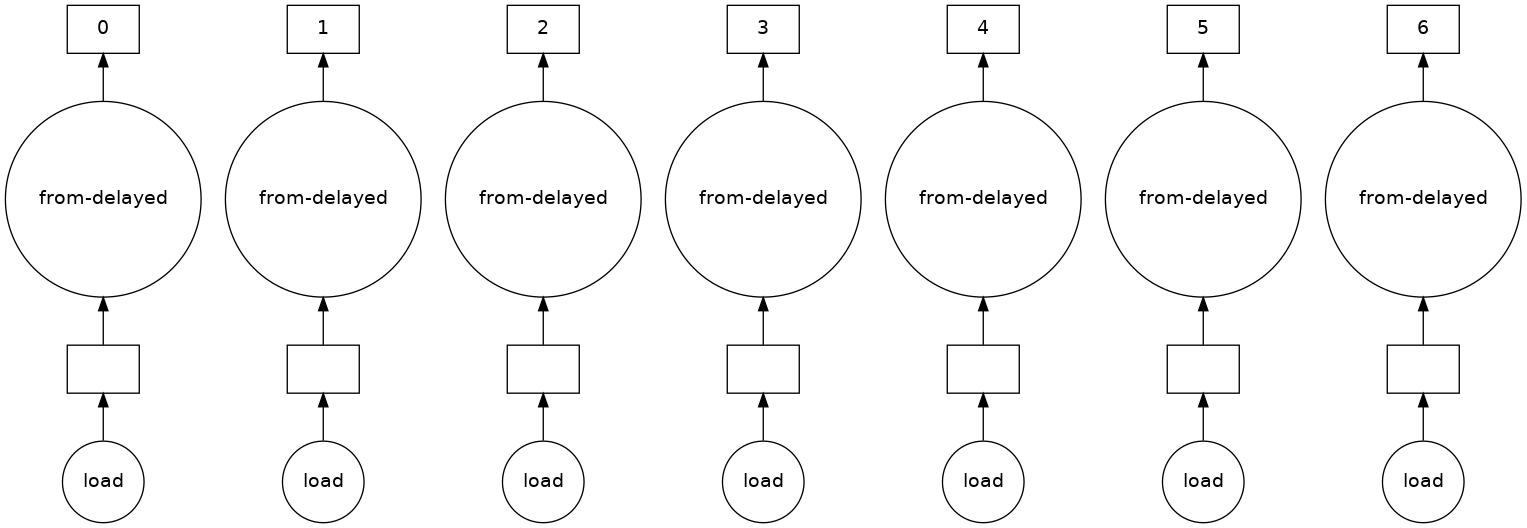

In [50]:
ddf.visualize()

Peek at the details of a dask dataframe 

In [51]:
print(ddf)

Dask DataFrame Structure:
              C_CUSTKEY  C_NAME C_ADDRESS C_NATIONKEY C_PHONE C_ACCTBAL C_MKTSEGMENT C_COMMENT
npartitions=7                                                                                 
                  int32  object    object        int8  object   float64       object    object
                    ...     ...       ...         ...     ...       ...          ...       ...
...                 ...     ...       ...         ...     ...       ...          ...       ...
                    ...     ...       ...         ...     ...       ...          ...       ...
                    ...     ...       ...         ...     ...       ...          ...       ...
Dask Name: from-delayed, 14 tasks


Repartition a dask dataframe to partition number 5

In [52]:
rpdf = ddf.repartition(npartitions=5)  

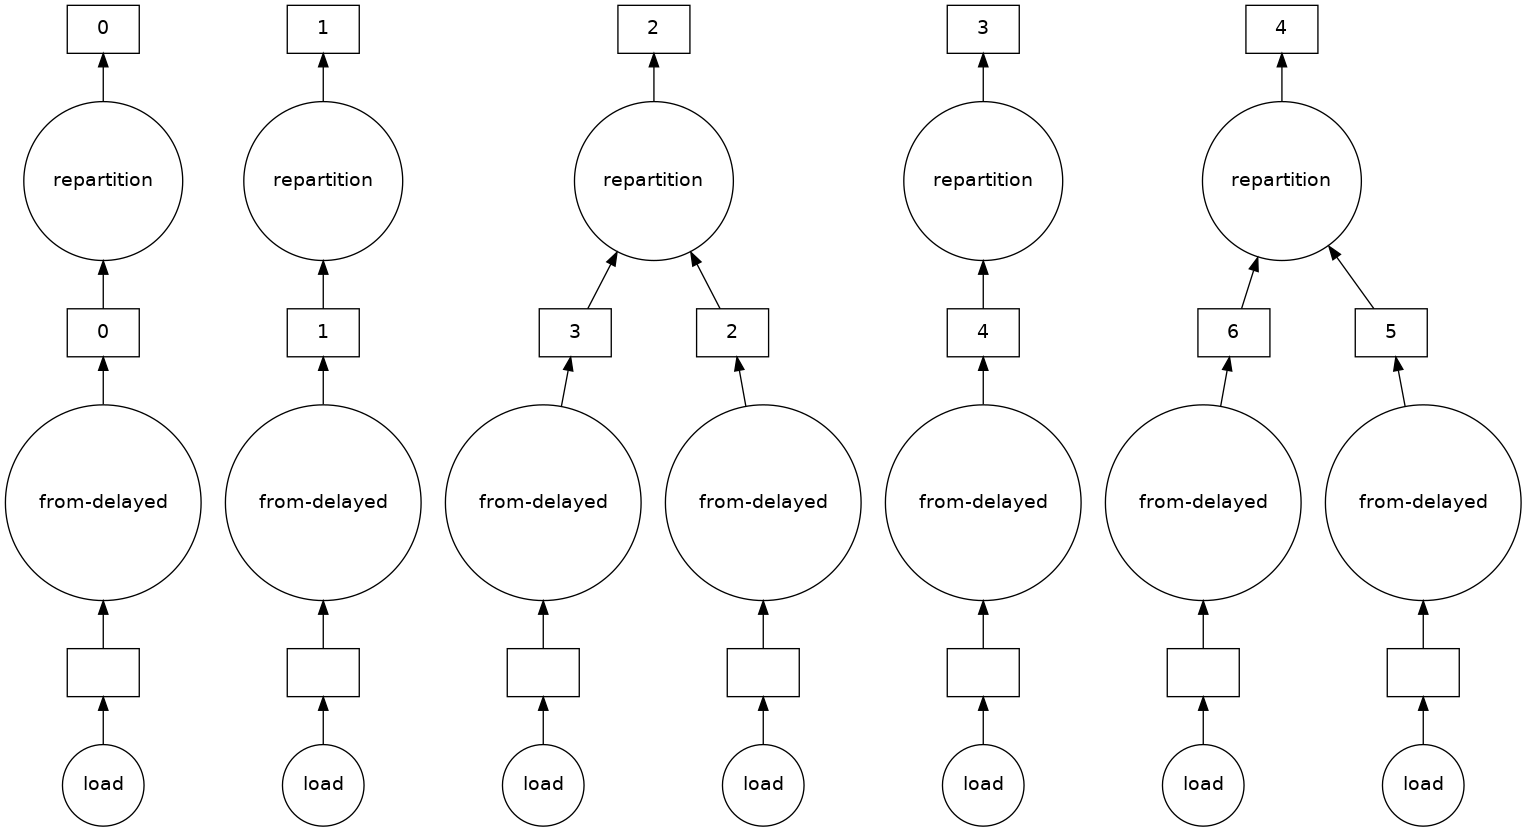

In [53]:
rpdf.visualize()

#### Write the dask dataframe to parquet files

In [54]:
import dask.dataframe as dd
import uuid

filename= uuid.uuid1()
parquet_path = f"/v3io/bigdata/pq_from_sf_dask/{filename}"
dd.to_parquet(df=rpdf,path=parquet_path)

[None]

#### Describe the dask dataframe

In [55]:
df_describe = ddf.describe().compute()
df_describe.head()

,C_CUSTKEY,C_NATIONKEY,C_ACCTBAL
count,8.000000e+04,80000.000000,80000.000000
mean,4.984117e+06,12.018137,4486.456041
std,2.629263e+06,7.229939,3177.308806
min,1.000000e+00,0.000000,-999.910000
25%,4.400498e+06,6.000000,2040.712500


#### Persist the dask datafrome to dask cluster as 'rpdf'

In [56]:
rpdf.persist(name='rpdf')

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
npartitions=5,,,,,,,,
,int32,object,object,int8,object,float64,object,object
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


#### List all the datasets in the dask cluster

In [57]:
client.list_datasets()  

()

#### Publish the dataset in the dask cluster that another client can access the dataframe

In [58]:
if not client.list_datasets():
    client.publish_dataset(rpdf=rpdf)

#### Get dataset 'rpdf' from the dask cluster

In [59]:
df = client.get_dataset('rpdf')
df.head()

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,4100001,Customer#004100001,cwYCpitc8dCU,13,23-947-805-6145,8064.52,MACHINERY,inal requests use blithely along the regu
1,4100002,Customer#004100002,OfamzjvUsg2l8YkWC9m17OeUvqMetJzWdiZPw,19,29-261-166-7418,7478.85,FURNITURE,"osits integrate carefully ironic, bold instruc..."
2,4100003,Customer#004100003,OdFvPvPc7Bv0DSHm,7,17-166-379-4908,9019.43,MACHINERY,ly final packages can cajole bold instructions...
3,4100004,Customer#004100004,"lTMvYGd,z CrsIBUFl5",14,24-299-747-3519,7606.59,FURNITURE,y excuses. furiously regular i
4,4100005,Customer#004100005,s4B19i lP1qOD,22,32-190-295-5100,-33.37,FURNITURE,rding to the unusual ideas. slyly expr


### Some screen capture for the blog post
![Dask Dashboard](dask-dashboard.png)

![Dask Workers Dashboard](dask-dashboard-workers.png)

![Dask executor-pods](dask-executor-pods.png)

![Snowflake Dashboard](snowflake-query-history.png)